Device set to use cpu
LibriSpeech Clean: 5it [00:24,  4.87s/it]
LibriSpeech Other: 5it [00:19,  3.82s/it]
Reading metadata...: 16354it [00:02, 7049.78it/s]
Common Voice: 5it [00:18,  3.61s/it]
VoxPopuli: 5it [00:22,  4.52s/it]
TEDLIUM: 5it [00:33,  6.74s/it]


Resolving data files:   0%|          | 0/2279 [00:00<?, ?it/s]

GigaSpeech: 5it [00:42,  8.47s/it]
SPGISpeech: 5it [00:23,  4.68s/it]


Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Earnings-22: 5it [00:41,  8.39s/it]
AMI: 5it [00:20,  4.13s/it]


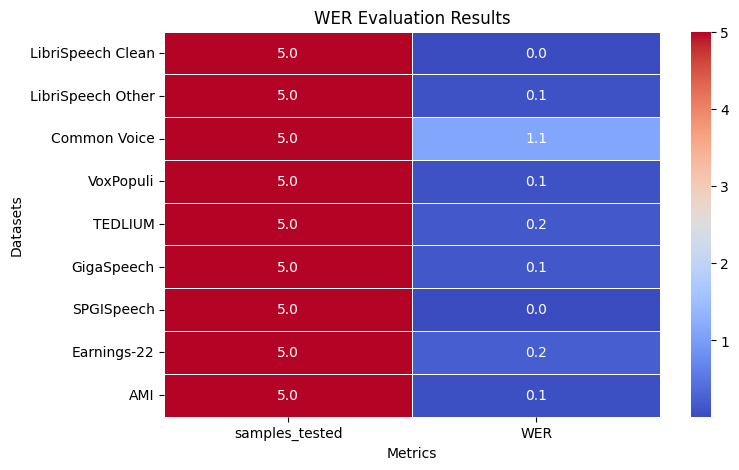

In [2]:
import torch
from transformers import pipeline, AutoModelForSpeechSeq2Seq, AutoProcessor
from datasets import load_dataset
import jiwer
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Text normalization transform
wer_transform = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords()
])

def calculate_wer(references, predictions):
    try:
        return jiwer.wer(
            references,
            predictions,
            truth_transform=wer_transform,
            hypothesis_transform=wer_transform
        )
    except:
        return float('inf')

# Initialize model
device = "cpu"
torch_dtype = torch.float32
model_id = "openai/whisper-small"

model = AutoModelForSpeechSeq2Seq.from_pretrained(model_id, torch_dtype=torch_dtype)
processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    device=device,
    torch_dtype=torch_dtype,
)

DATASET_CONFIG = [
    {"name": "LibriSpeech Clean", "path": "librispeech_asr", "config": "clean", "split": "test", "text_key": "text"},
    {"name": "LibriSpeech Other", "path": "librispeech_asr", "config": "other", "split": "test", "text_key": "text"},
    {"name": "Common Voice", "path": "mozilla-foundation/common_voice_11_0", "config": "en", "split": "test", "text_key": "sentence"},
    {"name": "VoxPopuli", "path": "facebook/voxpopuli", "config": "en", "split": "test", "text_key": "raw_text"},
    {"name": "TEDLIUM", "path": "LIUM/tedlium", "config": "release3", "split": "test", "text_key": "text"},
    {"name": "GigaSpeech", "path": "fixie-ai/gigaspeech", "config":"xl", "split": "test", "text_key": "text"},
    {"name": "SPGISpeech", "path": "kensho/spgispeech", "config":"S", "split": "test", "text_key": "transcript"},
    {"name": "Earnings-22", "path": "distil-whisper/earnings22", "config":"chunked", "split": "test", "text_key": "transcription"},
    {"name": "AMI", "path": "edinburghcstr/ami", "config": "ihm", "split": "test", "text_key": "text"}
]

def evaluate_dataset(dataset_config, max_samples=5):
    try:
        dataset = load_dataset(
            dataset_config["path"],
            dataset_config.get("config"),
            split=dataset_config["split"],
            streaming=True
        ).take(max_samples)
    except Exception as e:
        print(f"Error loading {dataset_config['name']}: {str(e)}")
        return None

    predictions, references = [], []
    
    for sample in tqdm(dataset, desc=dataset_config["name"]):
        try:
            # Validate audio
            audio = sample["audio"]["array"]
            if audio.size == 0 or audio.ndim != 1:
                raise ValueError("Invalid audio format")
                
            # Get text with dataset-specific key
            text = sample.get(dataset_config["text_key"])
            if not text or not isinstance(text, str):
                raise ValueError(f"Missing text in {dataset_config['name']}")
            
            # Get prediction
            result = pipe(
                audio,
                chunk_length_s=30,
                stride_length_s=(4, 2),
                generate_kwargs={"language": "<|en|>", "task": "transcribe"},
            )
            prediction = result["text"].strip()
            
            references.append(text.strip())
            predictions.append(prediction)
                
        except Exception as e:
            print(f"{dataset_config['name']} sample error: {str(e)}")
            continue

    if len(references) == 0:
        return None
        
    return {
        "dataset": dataset_config["name"],
        "samples_tested": len(references),
        "WER": calculate_wer(references, predictions)
    }

results = []
for config in DATASET_CONFIG:
    result = evaluate_dataset(config, max_samples=5)
    if result:
        results.append(result)

# Display results
if results:
    df = pd.DataFrame(results)
    df.set_index("dataset", inplace=True)
    plt.figure(figsize=(8, 5))
    sns.heatmap(df, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
    plt.title("WER Evaluation Results")
    plt.xlabel("Metrics")
    plt.ylabel("Datasets")
    plt.show()
else:
    print("No results to display")